In [5]:
from gibbs import GibbsFactorCopula
import numpy as np

In [6]:
import numpy as np

def simulate_heterogeneous_model(n_obs, n_assets, n_factors, 
                                 mu, phi, sigma_eta, nu, 
                                 seed=None):
    """
    Simule le modèle avec des paramètres dynamiques spécifiques à chaque actif.
    
    Args:
        mu, phi, sigma_eta : Peuvent être des scalaires (float) 
                             OU des tableaux numpy de taille (n_assets,) 
                             OU des tableaux de taille (n_assets, n_factors).
    """
    if seed is not None:
        np.random.seed(seed)
        
    # --- PRÉTRAITEMENT DES PARAMÈTRES ---
    # On s'assure que tout est au format (n_assets, n_factors) pour le calcul
    # Cela permet de gérer le cas "par actif" (vecteur) ou "par loading" (matrice)
    
    def format_param(param, name):
        p = np.array(param)
        if p.ndim == 0: # Scalaire
            return np.full((n_assets, n_factors), p)
        elif p.ndim == 1: # Vecteur (taille N) -> supposé identique pour tous les facteurs de l'actif
            if len(p) != n_assets:
                raise ValueError(f"La taille de {name} ({len(p)}) ne matche pas n_assets ({n_assets})")
            return p[:, np.newaxis] # Devient (N, 1) pour broadcaster sur les facteurs
        else: # Matrice (N, P)
            return p

    mu_mat = format_param(mu, 'mu')
    phi_mat = format_param(phi, 'phi')
    sig_mat = format_param(sigma_eta, 'sigma_eta')
    
    # --- SIMULATION ---
    
    # 1. Bruits
    # Facteurs communs
    f_t = np.random.normal(0, 1, size=(n_obs, n_factors))
    # Bruit idiosyncratique
    eps_t = np.random.normal(0, 1, size=(n_obs, n_assets))
    # Variable de mélange (Zeta)
    w = np.random.chisquare(df=nu, size=n_obs)
    zeta_t = nu / np.maximum(w, 1e-10)
    
    # Bruits d'état pour les Loadings
    # Notez qu'on multiplie par sig_mat ici pour appliquer la volatilité spécifique
    raw_eta = np.random.normal(0, 1, size=(n_obs, n_assets, n_factors))
    eta_t = raw_eta * sig_mat[np.newaxis, :, :] 

    # 2. Dynamique des Loadings (AR(1) vectorisé)
    lambdas = np.zeros((n_obs, n_assets, n_factors))
    
    # État initial : N(mu, sigma / sqrt(1-phi^2))
    # Calcul de la variance stationnaire spécifique à chaque élément
    std_stat = sig_mat / np.sqrt(1 - phi_mat**2)
    lambdas[0] = np.random.normal(mu_mat, std_stat)
    
    for t in range(1, n_obs):
        # La formule AR(1) s'applique élément par élément grâce aux matrices
        # lambda_t = mu + phi * (lambda_{t-1} - mu) + eta
        lambdas[t] = mu_mat + phi_mat * (lambdas[t-1] - mu_mat) + eta_t[t]
        
    # 3. Observations
    common_component = np.einsum('tnk,tk->tn', lambdas, f_t)
    scale_factor = np.sqrt(zeta_t)[:, np.newaxis]
    
    x = scale_factor * (common_component + eps_t)
    
    return x, lambdas, zeta_t

# --- EXEMPLE D'UTILISATION ---

N = 5
P = 1
T = 200

# Cas 1 : Paramètres "Par Actif" (Vecteurs de taille N)
# Disons que les actifs 0 à 2 sont très persistants (phi=0.99) et les autres moins (phi=0.8)
phi_per_asset = np.array([0.99, 0.99, 0.99, 0.80, 0.80])

# Disons que la volatilité des loadings varie
sigma_per_asset = np.random.uniform(0.05, 0.20, size=N)

# Simulation
x, L, z = simulate_heterogeneous_model(
    n_obs=T, n_assets=N, n_factors=P,
    mu=0.5,             # On garde mu constant (scalaire) pour l'exemple
    phi=phi_per_asset,  # Vecteur
    sigma_eta=sigma_per_asset, # Vecteur
    nu=5.0
)

print("Forme des loadings:", L.shape)
print("Exemple de Phi utilisé pour l'actif 1:", phi_per_asset[0])
print("Exemple de Phi utilisé pour l'actif 5:", phi_per_asset[4])

Forme des loadings: (200, 5, 1)
Exemple de Phi utilisé pour l'actif 1: 0.99
Exemple de Phi utilisé pour l'actif 5: 0.8


In [4]:
L

array([[[-0.30329498],
        [ 0.74460785],
        [ 2.24045496],
        [ 0.686529  ],
        [ 0.41836489]],

       [[-0.3642148 ],
        [ 0.71884882],
        [ 2.18584908],
        [ 0.78005603],
        [ 0.38884277]],

       [[-0.40011163],
        [ 0.79006261],
        [ 2.02514089],
        [ 0.80882067],
        [ 0.5149658 ]],

       [[-0.43651637],
        [ 0.85642957],
        [ 2.14986676],
        [ 0.70888242],
        [ 0.45828852]],

       [[-0.62005068],
        [ 0.78266352],
        [ 2.19473742],
        [ 0.68268873],
        [ 0.42136606]],

       [[-0.60337955],
        [ 0.6714905 ],
        [ 2.26761509],
        [ 0.57396883],
        [ 0.49748628]],

       [[-0.56752275],
        [ 0.81701199],
        [ 2.16936949],
        [ 0.62771659],
        [ 0.5885303 ]],

       [[-0.4943772 ],
        [ 0.82538479],
        [ 2.19812784],
        [ 0.63180491],
        [ 0.64407432]],

       [[-0.34342894],
        [ 0.86602683],
        [ 2.527819

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

# Import de votre module local
from gibbs import GibbsFactorCopula

def simulate_factor_copula_data(T=200, N=5, p=1, nu_true=5.0):
    """
    Simule des données synthétiques cohérentes avec le modèle GibbsFactorCopula.
    """
    np.random.seed(42)
    
    # 1. Paramètres des processus AR(1) pour les chargements (Lambdas)
    # h_{t+1} = mu + phi * (h_t - mu) + sigma * eta
    true_mu = np.random.normal(0.0, 0.3, size=(N, p))
    true_phi = np.random.uniform(0.7, 0.95, size=(N, p))
    true_sigma = np.ones((N, p)) * 0.1
    
    # 2. Génération des variables latentes
    # Facteurs z_t ~ N(0, I)
    z_true = np.random.normal(size=(T, p))
    
    # Variable de mélange zeta_t ~ InvGamma(nu/2, nu/2)
    # Note: scipy invgamma prend a (shape). scale = b. 
    # Si X ~ Gamma(shape, scale), 1/X ~ InvGamma.
    gamma_rv = np.random.gamma(shape=nu_true/2.0, scale=2.0/nu_true, size=(T, 1))
    zeta_true = 1.0 / gamma_rv
    
    # 3. Génération des trajectoires des chargements (Lambdas)
    latent_h = np.zeros((T, N, p))
    lambdas_true = np.zeros((T, N, p))
    
    # Initialisation
    latent_h[0] = true_mu
    
    for t in range(1, T):
        noise = np.random.normal(0, 1, size=(N, p))
        latent_h[t] = true_mu + true_phi * (latent_h[t-1] - true_mu) + true_sigma * noise
        
    # Transformation (Identification des contraintes)
    # Si i < p (diagonale triangulaire inférieure), on prend exp()
    lambdas_true = latent_h.copy()
    for i in range(p):
        if i < N: # Sécurité si N < p
            lambdas_true[:, i, i] = np.exp(latent_h[:, i, i])
            # Les éléments au-dessus de la diagonale restent à 0 (implicite dans le modèle)
            
    # 4. Génération des Observations X
    # Le modèle dans gibbs.py implique:
    # X_t ~ N( mean_obs, scale_obs )
    # mean_obs = sqrt(zeta) * (lambda * z) / sqrt(1 + lambda^2)
    # scale_obs = sqrt(zeta) * 1 / sqrt(1 + lambda^2)
    
    X = np.zeros((T, N))
    
    for t in range(T):
        zt = z_true[t]       # (p,)
        zetat = zeta_true[t] # (1,)
        
        for i in range(N):
            lam_i = lambdas_true[t, i] # (p,)
            
            # Produit scalaire facteur * loading
            factor_comp = np.dot(lam_i, zt)
            
            # Mise à l'échelle (scaling)
            lam_sq = np.sum(lam_i**2)
            scaling = np.sqrt(1.0 + lam_sq)
            
            # Paramètres de la loi Normale conditionnelle
            zeta_sqrt = np.sqrt(zetat)
            mean_obs = zeta_sqrt * (factor_comp / scaling)
            scale_obs = zeta_sqrt * (1.0 / scaling)
            
            # Tirage de l'observation
            X[t, i] = np.random.normal(loc=mean_obs, scale=scale_obs)
            
    return X, lambdas_true, latent_h, z_true, zeta_true, true_mu, true_phi, true_sigma

# --- Lancement de la simulation ---
T_sim = 200
N_sim = 5
p_sim = 1
nu_sim = 6.0

print(f"Simulation de {T_sim} périodes pour {N_sim} actifs et {p_sim} facteur(s)...")
data, true_lam, true_h, true_z, true_zeta, true_mu, true_phi, true_sigma = simulate_factor_copula_data(T_sim, N_sim, p_sim, nu_sim)
print("Données simulées. Shape:", data.shape)

Simulation de 200 périodes pour 5 actifs et 1 facteur(s)...
Données simulées. Shape: (200, 5)


C:\Users\vautr\AppData\Local\Temp\ipykernel_4000\2004594761.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[t, i] = np.random.normal(loc=mean_obs, scale=scale_obs)


In [16]:
# Initialisation du modèle
gibbs = GibbsFactorCopula(data, n_factors=p_sim, nu=10)

# Vérification rapide des dimensions
print(f"Modèle initialisé.")
print(f"Initial Nu: {gibbs.nu}")
print(f"Initial Latent States Shape: {gibbs.latent_states.shape}")

Modèle initialisé.
Initial Nu: 10
Initial Latent States Shape: (200, 5, 1)


Démarrage du Gibbs Sampler...


100%|██████████| 2000/2000 [06:01<00:00,  5.53it/s]


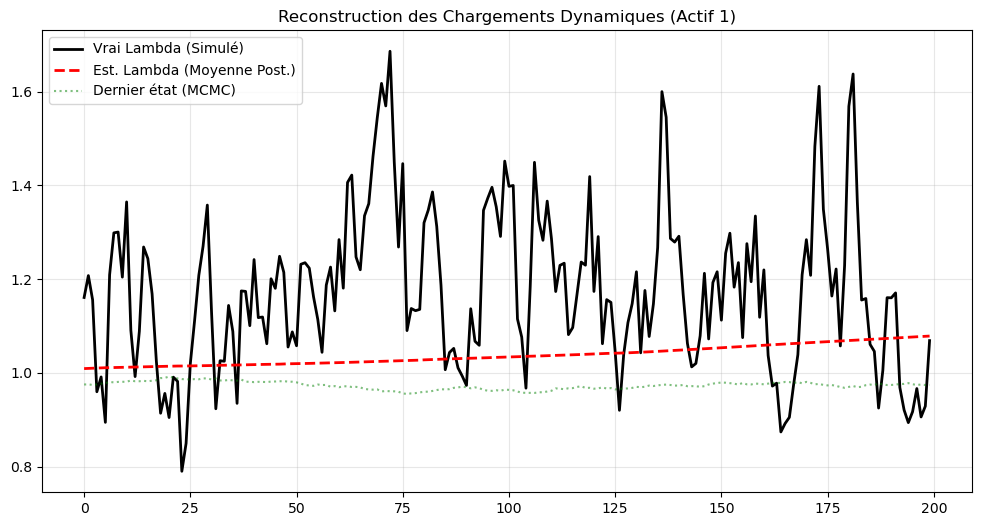

Vrai Nu: 6.0, Estimé Nu (dernier): 8.59


In [17]:
# Paramètres MCMC
n_burnin = 500
n_iter = 2000  # Gardé court pour l'exemple, augmentez à 1000+ pour convergence réelle

# Stockage pour les moyennes a posteriori (optionnel)
post_lambda_mean = np.zeros_like(true_lam)
post_mu_mean = np.zeros_like(gibbs.theta['mu'])
post_phi_mean = np.zeros_like(gibbs.theta['phi'])
post_sigma_mean = np.zeros_like(gibbs.theta['sigma'])

print("Démarrage du Gibbs Sampler...")
for it in tqdm(range(n_iter)):
    
    # 1. Mise à jour des variables de mélange (InvGamma)
    gibbs.update_zeta()
    
    # 2. Mise à jour des degrés de liberté (Metropolis)
    gibbs.update_nu(rw_step=0.5)
    
    # 3. Mise à jour des facteurs latents (Normal)
    gibbs.update_z()
    
    # 4. Mise à jour des chargements Lambda (Particle Gibbs)
    # Si vous avez joblib installé et configuré dans gibbs.py, utilisez update_lambda_pg_parallel
    # Sinon utilisez update_lambda_pg standard
    gibbs.update_lambda_pg() 
    
    # 5. Mise à jour des hyperparamètres statiques
    gibbs.update_sigma()
    gibbs.update_mu_phi()
    
    # Stockage après burn-in
    if it > n_burnin:
        post_lambda_mean += gibbs.lambdas
        post_mu_mean += gibbs.theta['mu']
        post_phi_mean += gibbs.theta['phi']
        post_sigma_mean += gibbs.theta['sigma']

    

# Moyenne des itérations
post_lambda_mean /= (n_iter - n_burnin)

# --- Visualisation ---
plt.figure(figsize=(12, 6))

# On trace le premier chargement du premier actif
asset_idx = 0
factor_idx = 0

plt.plot(true_lam[:, asset_idx, factor_idx], 'k-', lw=2, label='Vrai Lambda (Simulé)')
plt.plot(post_lambda_mean[:, asset_idx, factor_idx], 'r--', lw=2, label='Est. Lambda (Moyenne Post.)')
plt.plot(gibbs.lambdas[:, asset_idx, factor_idx], 'g:', alpha=0.5, label='Dernier état (MCMC)')

plt.title(f"Reconstruction des Chargements Dynamiques (Actif {asset_idx+1})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Vrai Nu: {nu_sim}, Estimé Nu (dernier): {gibbs.nu:.2f}")

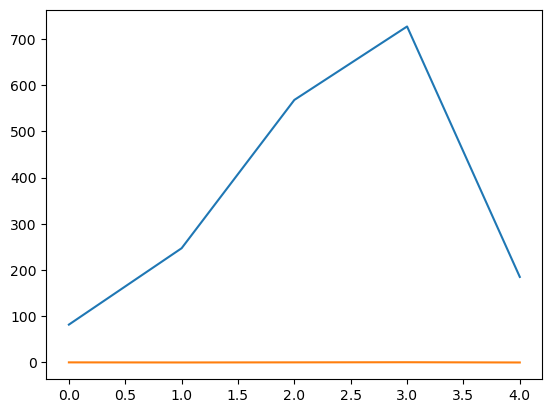

In [18]:
plt.plot(post_mu_mean)
plt.plot(true_mu)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from gibbs import GibbsFactorCopula

# --- 1. Define the simulation function (from Cell 1 of the notebook) ---
def simulate_heterogeneous_model(n_obs, n_assets, n_factors, 
                                 mu, phi, sigma_eta, nu, 
                                 seed=2):
    if seed is not None:
        np.random.seed(seed)
        
    def format_param(param, name):
        p = np.array(param)
        if p.ndim == 0:
            return np.full((n_assets, n_factors), p)
        elif p.ndim == 1:
            if len(p) != n_assets:
                raise ValueError(f"La taille de {name} ({len(p)}) ne matche pas n_assets ({n_assets})")
            return p[:, np.newaxis]
        else:
            return p

    mu_mat = format_param(mu, 'mu')
    phi_mat = format_param(phi, 'phi')
    sig_mat = format_param(sigma_eta, 'sigma_eta')
    
    f_t = np.random.normal(0, 1, size=(n_obs, n_factors))
    eps_t = np.random.normal(0, 1, size=(n_obs, n_assets))
    w = np.random.chisquare(df=nu, size=n_obs)
    zeta_t = nu / np.maximum(w, 1e-10)
    
    raw_eta = np.random.normal(0, 1, size=(n_obs, n_assets, n_factors))
    eta_t = raw_eta * sig_mat[np.newaxis, :, :] 

    lambdas = np.zeros((n_obs, n_assets, n_factors))
    std_stat = sig_mat / np.sqrt(1 - phi_mat**2)
    lambdas[0] = np.random.normal(mu_mat, std_stat)
    
    for t in range(1, n_obs):
        lambdas[t] = mu_mat + phi_mat * (lambdas[t-1] - mu_mat) + eta_t[t]
        
    # Adjustment for the Copula Model (scaling by sqrt(1 + sum lambda^2))
    # to match the likelihood in gibbs.py
    # x = sqrt(zeta) * (lambda * f + eps) / sqrt(1 + sum lambda^2)
    
    x = np.zeros((n_obs, n_assets))
    for t in range(n_obs):
        lam_t = lambdas[t] # (N, P)
        z_t = f_t[t]       # (P,)
        zetat = zeta_t[t]  # (1,)
        
        factor_comp = np.dot(lam_t, z_t) # (N,)
        lam_sq = np.sum(lam_t**2, axis=1) # (N,)
        scaling = np.sqrt(1.0 + lam_sq)
        
        zeta_sqrt = np.sqrt(zetat)
        mean_obs = zeta_sqrt * (factor_comp / scaling)
        scale_obs = zeta_sqrt * (1.0 / scaling)
        
        x[t] = np.random.normal(loc=mean_obs, scale=scale_obs)
    
    return x, lambdas, zeta_t

# --- 2. Run Simulation ---
N = 5
P = 1
T = 300
phi_per_asset = 0.8 # np.array([0.99, 0.99, 0.99, 0.80, 0.80])
sigma_per_asset = 0.1 #np.array([0.1, 0.12, 0.15, 0.08, 0.05])
mu_true = 0.5
nu_true = 5.0

x, true_lambdas, true_zeta = simulate_heterogeneous_model(
    n_obs=T, n_assets=N, n_factors=P,
    mu=mu_true,
    phi=phi_per_asset,
    sigma_eta=sigma_per_asset,
    nu=nu_true,
    seed=2
)

# --- 3. Run Gibbs Sampler ---
gibbs = GibbsFactorCopula(x, n_factors=P, nu=5)
n_burnin = 50 # Low for quick execution in this context, but better for demo
n_iter = 500

post_lambda_sum = np.zeros_like(true_lambdas)
post_mu_sum = np.zeros_like(gibbs.theta['mu'])
post_phi_sum = np.zeros_like(gibbs.theta['phi'])

print("Starting Gibbs Sampler...")
for it in tqdm(range(n_iter)):
    gibbs.update_zeta()
    #gibbs.update_nu(rw_step=0.5)
    gibbs.update_z()
    gibbs.update_lambda_pg() # Using non-parallel for stability in this env
    gibbs.update_sigma()
    gibbs.update_mu_phi()
    
    if it >= n_burnin:
        post_lambda_sum += gibbs.lambdas
        post_mu_sum += gibbs.theta['mu']
        post_phi_sum += gibbs.theta['phi']

post_lambda_mean = post_lambda_sum / (n_iter - n_burnin)
post_mu_mean = post_mu_sum / (n_iter - n_burnin)
post_phi_mean = post_phi_sum / (n_iter - n_burnin)

# --- 4. Visualization ---
plt.figure(figsize=(12, 6))
# plot des mus
plt.plot(post_mu_mean, label='Estimated Mu (Posterior Mean)')
plt.plot(mu_true, label='True Mu', linestyle='--')
plt.title("Estimation de Mu")
plt.legend()

Starting Gibbs Sampler...


  5%|▍         | 24/500 [00:06<02:06,  3.75it/s]

In [ ]:
gibbs.theta['mu']

array([[ 0.93656961],
       [-0.38274786],
       [-0.49798228],
       [-0.11390123],
       [ 0.62354309]])

In [22]:
post_mu_mean

array([[-0.47156615],
       [ 0.0290238 ],
       [ 0.33602639],
       [ 0.50900792],
       [ 0.570522  ]])